# Step3 演習01 オーバーフィッティング対策
---

本演習では、ニューラルネットワークのモデルを構築し、機械学習界の Hello World 手書き数字の画像データMNISTの、多クラス分類をおこないます。

その際にモデルがオーバーフィッティングしてしまった場合の対策の１つである正則化を実装することで、過学習が抑制されることを確認します。


**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- 手書き数字０から９の10クラスのMNISTのデータセットを利用し、多クラス分類を行う。
- 過学習を起こしてしまったモデルに対してL2正則化とL1正則化を実装し、オーバーフィッティングを解決する。

## ライブラリのインポート

まずはじめに、本演習で利用するライブラリのインポートをします。ライブラリのインポートは一番はじめに行うようにしましょう。

- [NumPy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [Matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番**に順次実行してください。

**注意**： 初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## データセットの準備

この演習では "MNIST" と呼ばれる手書き数字のデータを用います。

28ピクセル×28ピクセルのグレースケール画像が学習用データとして55,000枚、テスト用データとして10,000枚含まれています。

今回はTensorFlowで用意されている関数を使ってデータを読み込みます。

read_data_setsの引数は
1. ファイルの保存場所
2. one_hot: one-hotベクトル化するかどうか
3. validation_size: 検証用データの枚数、今回は訓練データとテストデータのみ使用します

使用しているネットワークの強さによりロードに多少時間がかかる場合があります。

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ダウンロードしたデータセットを訓練データとテストデータとしてそれぞれ定義しておきます。

** 変数名 **
- X_train：訓練データ
- y_train：訓練データの正解ラベル
- X_test：テストデータ
- y_test：テストデータの正解ラベル

In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

print("X_train：訓練データ")
print("y_train：訓練データの正解ラベル")
print("X_test：テストデータ")
print("y_test：テストデータの正解ラベル")

X_train：訓練データ
y_train：訓練データの正解ラベル
X_test：テストデータ
y_test：テストデータの正解ラベル


訓練データとテストデータを確認しましょう。

In [4]:
print("訓練データ数：{}".format(X_train.shape[0]))
print("訓練データ数の特徴：{}".format(X_train.shape[1]))
print("テストデータ数：{}".format(X_test.shape[0]))
print("テストデータ数の特徴：{}".format(X_test.shape[1]))

訓練データ数：55000
訓練データ数の特徴：784
テストデータ数：10000
テストデータ数の特徴：784


"X_train：訓練データ"は、学習用データの55000枚の画像データを行列にしたもの（28×28=784）として格納されています。

同様に、"X_test：テストデータ"は、テスト用データの10000枚の画像データを行列にしたもの（28×28=784）として格納されています。

In [5]:
#訓練データの数をmに格納しておきます。
m = X_train.shape[0]

In [6]:
m

55000

### データセットをシャッフルしよう

MNISTのデータセットをシャッフルします。データセットをそのまま使わずにシャッフルするのはなぜでしょうか。

例えば、データがラベル(y)に対してソートされていたとします。

すると、そのまま冒頭3000サンプルを取って学習に使うと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。

一見分からないような規則でソートされている可能性もあるので、データセットの順番がバラバラに見えても必ず最初にシャッフルしてください。

下のセルを実行すると**訓練データ**をランダムな配列にシャッフルしてくれます。

In [7]:
permutation = np.random.permutation(mnist.train.images.shape[0])
X_train = mnist.train.images[permutation]
y_train = mnist.train.labels[permutation]

## データの可視化

配列 X_train には55000枚の画像データ(pixel)が、一列に並んで入っています。X_trainのshapeは(55000, 784)です。

この画像を表示させるには、一列（ベクトル）に並んでしまっている55000枚の画像データをそれぞれ２次元(28, 28)に戻す必要があります。

それにはNumPyの "reshape" を使います。

ここで学習データの画像をランダムに表示させてみます。セルを実行するたびに画像が変わります。

数字：9


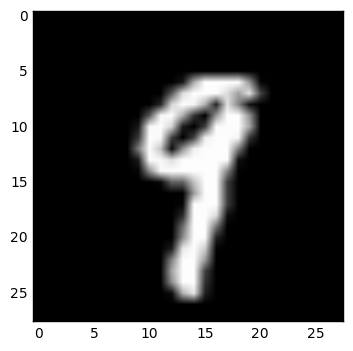

In [8]:
num = np.random.randint(0, len(mnist.train.images))
plt.imshow(mnist.train.images[num].reshape(28, 28), cmap='gray')
print("数字：{}".format(np.argmax(mnist.train.labels[num])))

MNISTの画像一枚が表示されたと思います。さらに、画像に対応する数字が画像の上に表示されていると思います。

次に正解ラベルについて見てみましょう。

正解ラベルの y_train のshapeは(55000,10)です。次のセルのprint文を実行して訓練データとテストデータの正解ラベルを確認します。

In [9]:
print("訓練データの正解ラベル数：{}".format(y_train.shape[0]))
print("訓練データ数の正解ラベルの要素数：{}".format(y_train.shape[1]))
print("テストデータの正解ラベル数：{}".format(y_test.shape[0]))
print("テストデータ数の正解ラベルの要素数：{}".format(y_test.shape[1]))

訓練データの正解ラベル数：55000
訓練データ数の正解ラベルの要素数：10
テストデータの正解ラベル数：10000
テストデータ数の正解ラベルの要素数：10


訓練データの場合、正解ラベル数は55000となっており、それぞれに対して答えとなるラベル部分には「１」が与えられています。

下のセルを実行してください。

In [10]:
y_train[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

例えば、数字の０に対応するラベルは、配列の0番目に１がはいっています。

数字の1に対応するラベルには、配列の1番目に1がはいっています。３以降も同様のルールです。

以下にそれらを可視化してあるので確認してください。
<p>

<div align="center"  style="width:50%">
<img src="./img/step3_mnist_label_019.png"></div>

one-of-k または、one-hotエンコーディングと呼びます。

これまで１つのMNSITのデータをみてきました。少し物足りなさもあるので、MNIST１００個の画像を表示するプログラミムを定義しておきます。

In [11]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

実際に表示させてみます。下のセルを実行すると100枚の画像が表示されます。

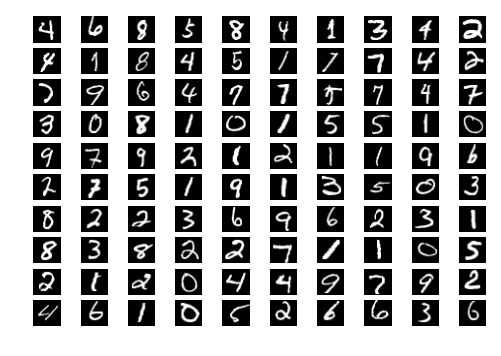

In [12]:
displayData(X_train[:100, :])

---

### データセットを分割

本演習では、訓練に使うデータセットを訓練集合を3000枚、テスト集合を1000枚に分割します。

In [13]:
# データセットを仕分ける
X_train = X_train[:3000]
y_train = y_train[:3000]
X_test = X_test[:1000]
y_test = y_test[:1000]

訓練データとテストデータの数を確認しましょう。

In [14]:
print("訓練データ数：{}".format(X_train.shape[0]))
print("テストデータ数：{}".format(X_test.shape[0]))

訓練データ数：3000
テストデータ数：1000


"X_train：訓練データ"は、学習用データの3000枚の画像データを行列にしたもの（28×28=784）として格納されています。

同様に、"X_test：テストデータ"は、テスト用データの1000枚の画像データを行列にしたもの（28×28=784）として格納されています。

## データセットの正規化

ここではデータを整える正規化を行います。データセット全体が平均0.0，分散1.0となるように正規化しましょう。

下のセルを実行してください。

In [15]:
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

## ニューラルネットワークのモデル

これまでは学習に利用するMNISTのデータセットの性質を、訓練データとテストデータに分けてそれぞれ確認してきました。

ここからは今回の演習で用いるニューラルネットワークのモデルを構築します。

入力層のユニット数は特徴の数である784個、出力層は0~9の数字の１０クラス分、隱れ層のユニット数は100個とします。

ここでは下記の条件で、ニューラルネットワークのモデルを構築します：

- 入力層のユニット数784個
- 隠れ層のユニット数100個
- 出力層のユニット数10個

In [17]:
# ニューラルネットワークの構造を決める
input_size = 784
hidden_size = 100
output_size = 10

### 活性化関数

ニューラルネットワークのモデルで利用する活性化関数を下記のように実装します。

- 隠れ層の活性化関数：シグモイド関数
- 出力層の活性化関数：ソフトマックス関数

In [18]:
# シグモイド関数
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y
    
#シグモイド関数の微分
def sigmoid_derivative(x):
    y = sigmoid(x) * (1 - sigmoid(x))
    return y

#ソフトマックス関数
def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x - c)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### ニューラルネットワークのモデル

下記の項目の関数を次のセルのように実装します。

- initialize_parameters：パラメータの初期化
- forward_propagation：フォワードプロパゲーション
- compute_cost：コスト関数
- backward_propagation：バックプロパゲーション
- update_parameters：パラメータの更新
- accuracy：正解率

In [19]:
def initialize_parameters(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size)
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

def forward_propagation(X, W1, b1, W2, b2):
    layer1_z = np.dot(X, W1) + b1
    layer1_a = sigmoid(layer1_z)
    layer2_z = np.dot(layer1_a, W2) + b2
    layer2_a = softmax(layer2_z)
    return layer1_z, layer1_a, layer2_z, layer2_a

def compute_cost(y, y_hat, m):
    cost = - np.sum(y * np.log(y_hat) ) / m        
    return cost

def backward_propagation(X, y, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size):
    derivative_layer2_z = (layer2_a - y) / batch_size 
    delta_W2 = np.dot(layer1_a.T, derivative_layer2_z)
    delta_b2 = np.sum(derivative_layer2_z, axis=0 ,keepdims=True) 
    derivative_layer1_z = np.dot(derivative_layer2_z, W2.T) * sigmoid_derivative(layer1_z)
    delta_W1 = np.dot(X.T, derivative_layer1_z)
    delta_b1 = np.sum(derivative_layer1_z, axis=0 ,keepdims=True) 
    return delta_W2, delta_b2, delta_W1, delta_b1

def update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate):
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1    
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    return W1, b1, W2, b2

def accuracy(y, y_hat):
    accuracy = (np.argmax(y,axis=1) == np.argmax(y_hat,axis=1))
    accuracy = accuracy.mean()
    return accuracy

### ニューラルネットワークのモデルを構築

Setp2 演習02 課題10  で実装したニューラルネットワークのモデルの関数 nn_model を下のセルに書いています。

そのまま実行してください。

In [20]:
# ニューラルネットワークのモデルを構築
def nn_model(X, y, X_test, y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate,  print_cost=False):

    # コスト/精度を記録するための配列
    train_Data_cost = []
    train_Data_acc = []
    test_Data_cost = []
    test_Data_acc = []
    
    #エポックのカウントとパラメータを初期化
    count = 0    
    W1,b1,W2,b2 = initialize_parameters(input_size, hidden_size, output_size)
     
    #エポック
    for i in range(epochs):
        #ミニバッチ
        for i in range(0, sample_size, batch_size):
         
            #ミニバッチ処理
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
        
            #フォワードプロパゲーション
            layer1_z, layer1_a, layer2_z, layer2_a = forward_propagation(X_batch, W1,b1,W2, b2)
            
            #バックプロパゲーション
            delta_W2, delta_b2, delta_W1, delta_b1 = backward_propagation(X_batch, y_batch, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size)
            
            #パラメータの更新
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate)

        
        #訓練データのエポックごとのコスト値
        train_output = forward_propagation(X, W1,b1,W2, b2)
        train_cost = compute_cost(y, train_output[3], sample_size)
        train_Data_cost.append(train_cost)
        
        #訓練データのエポックごとの精度
        train_acc = accuracy(y, train_output[3])
        train_Data_acc.append(train_acc)
        
        #テストデータのエポックごとのコスト値
        test_output = forward_propagation(X_test, W1,b1,W2, b2)
        test_cost = compute_cost(y_test, test_output[3], y_test.shape[0])
        test_Data_cost.append(test_cost)
        
        #テストデータのエポックごとの精度
        test_acc = accuracy(y_test, test_output[3])
        test_Data_acc.append(test_acc)

        #エポック数をカウント
        count += 1
        print('epochs：{0:.0f}'.format(int(count)), 'train cost：{0:.2f}'.format(train_cost),'train acc：{0:.2f}%'.format(train_acc*100))
    
    print("Finish Leaning!!")
    
    return train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2

関数 nn_model() に各パラメータを与え、学習を実行させます。ここではひとまず以下のとおりパラメータを設定します。

- input_size = 784
- hidden_size = 100
- output_size = 10
- epochs = 50
- sample_size = X_train.shape[0]
- batch_size = 100
- learning_rate = 0.1

In [21]:
input_size = 784
hidden_size = 100
output_size = 10
epochs = 50
sample_size = X_train.shape[0] #3000個
batch_size = 100
learning_rate = 0.1

以下のセルを実行するとモデルの学習がはじまります。

In [22]:
train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2 = \
nn_model(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, print_cost=True)

epochs：1 train cost：4.62 train acc：22.03%
epochs：2 train cost：3.43 train acc：33.23%
epochs：3 train cost：2.73 train acc：41.83%
epochs：4 train cost：2.28 train acc：47.60%
epochs：5 train cost：1.95 train acc：53.53%
epochs：6 train cost：1.72 train acc：58.00%
epochs：7 train cost：1.54 train acc：61.90%
epochs：8 train cost：1.40 train acc：64.67%
epochs：9 train cost：1.28 train acc：66.67%
epochs：10 train cost：1.19 train acc：68.87%
epochs：11 train cost：1.11 train acc：70.80%
epochs：12 train cost：1.04 train acc：72.23%
epochs：13 train cost：0.97 train acc：74.13%
epochs：14 train cost：0.92 train acc：75.63%
epochs：15 train cost：0.87 train acc：76.53%
epochs：16 train cost：0.83 train acc：78.00%
epochs：17 train cost：0.79 train acc：79.03%
epochs：18 train cost：0.76 train acc：79.93%
epochs：19 train cost：0.73 train acc：80.70%
epochs：20 train cost：0.70 train acc：81.37%
epochs：21 train cost：0.67 train acc：82.10%
epochs：22 train cost：0.65 train acc：82.70%
epochs：23 train cost：0.63 train acc：83.20%
epochs：24 train cost

## コスト減少のグラフ

コスト関数が最適化されてコストが減少していく様子をプロットします。

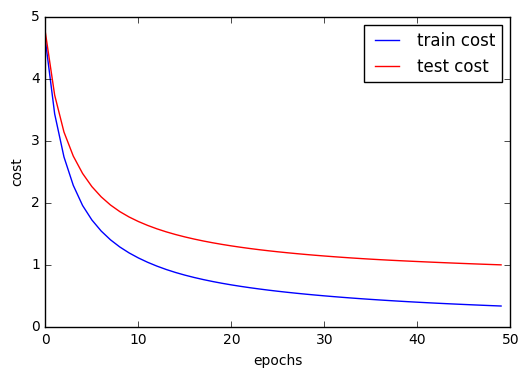

In [23]:
plt.plot(train_Data_cost, c='b', label='train cost')
plt.plot(test_Data_cost, c='r', label='test cost')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

訓練集合のコストは減少しているのに対して、テスト集合のコストはあまりうまく下がっていないデータになっているはずです。

**過学習（オーバーフィッティング）**が起こっていることが予想されます。

では、学習精度を確かめてみましょう。

## 学習精度のグラフ

エポックごとに学習精度が向上していく様子をプロットします。

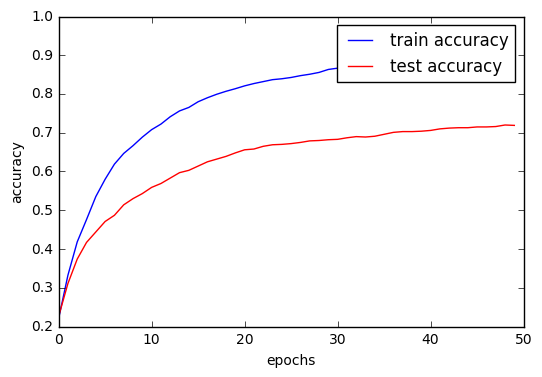

In [24]:
plt.plot(train_Data_acc, c='b', label='train accuracy')
plt.plot(test_Data_acc, c='r', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

訓練データに対しては精度高く学習することができていますが、テスト集合に関してはうまく学習することができていません。

### 実際に予測してみる

学習後のパラメータを使って、訓練データとテストデータの精度を確認してみましょう。

In [25]:
hidden = np.dot(X_train, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_train , axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

training accuracy: 0.92


次に、テストデータを使ってモデルの精度を確認してみましょう。

In [26]:
hidden = np.dot(X_test, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_test,axis=1)
print ('test accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

test accuracy: 0.72


### 重みの分布

入力層から隠れ層にかけての重みの値の分布をヒストグラムを使って確認してみます。これから実装する正則化を加えたときの重みの分布と比べてみましょう。

In [27]:
nn = W1.reshape(78400, )

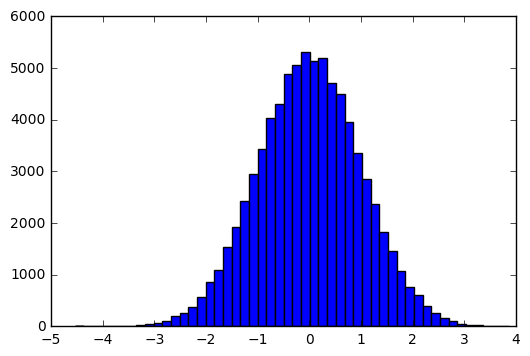

In [28]:
plt.hist(nn, bins=50)
plt.show()

## L2正則化

ここでは、オーバーフィッティング対策の１つの手法であるL2正則化を行ないます。

L2正則化ではコスト関数の勾配に関するパラメータの更新式のみ変更すればよかったので、関数 update_parameters を書き換えます。
<br>

**【課題１】** update_parameters_reg2()を実装してください。

**Note:**
$$w=(1-\alpha\lambda)w-\alpha\frac{\partial{C}}{\partial{w}}$$
$$b=b-\alpha\frac{\partial{C}}{\partial{b}}$$

- $\alpha$：学習率
- $\lambda$：正則化パラメータ

In [29]:
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)

(784, 100)
(1, 100)
(100, 10)
(1, 10)


In [30]:
#Coursedele-02 Step3 QuestionNumber1 8e3edb30d392c910f3b3458c8bc52aae
def update_parameters_reg2(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate, reg):
    ###############START CODE HERE###############
    W1 = (1 - learning_rate * reg) * W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1
    W2 = (1 - learning_rate * reg) * W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    ################END CODE HERE################
    return W1, b1, W2, b2

**ファイルを保存後** 、次のセルを実行（Shift+Enter）で採点を行います。

In [31]:
%%bash
./validation_client.py dele-02 3 1 Step3_01.ipynb api.internal.zero2one.jp

Congraturation!
We give you 10 points out of 10 points.



update_parameters_reg2()の実装がおわったら、nn_model()のコードを流用してニューラルネットワークのモデルを構築します。

nn_model_reg2()を実装します。

ここでは、下のセル内のパラメータ更新の関数 update_parameters() を update_parameters_reg2()に書き換えました。

下のセルをそのまま実行してください。

In [32]:
# ニューラルネットワークのモデルを構築
def nn_model_reg2(X, y, X_test,y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, reg, print_cost=False):

    # コスト/精度を記録するための配列
    train_Data_cost = []
    train_Data_acc = []
    test_Data_cost = []
    test_Data_acc = []
    
    #エポックのカウントとパラメータを初期化
    count = 0    
    W1,b1,W2,b2 = initialize_parameters(input_size, hidden_size, output_size)
     
    #エポック
    for i in range(epochs):
        #ミニバッチ
        for i in range(0, sample_size, batch_size):
         
            #ミニバッチ処理
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
        
            #フォワードプロパゲーション
            layer1_z, layer1_a, layer2_z, layer2_a = forward_propagation(X_batch, W1,b1,W2, b2)
            
            #バックプロパゲーション
            delta_W2, delta_b2, delta_W1, delta_b1 = backward_propagation(X_batch, y_batch, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size)
            
            #パラメータの更新
            W1, b1, W2, b2 = update_parameters_reg2(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate, reg)

        
        #訓練データのエポックごとのコスト値
        train_output = forward_propagation(X, W1,b1,W2, b2)
        train_cost = compute_cost(y, train_output[3], sample_size)
        train_Data_cost.append(train_cost)
        
        #訓練データのエポックごとの精度
        train_acc = accuracy(y, train_output[3])
        train_Data_acc.append(train_acc)
        
        #テストデータのエポックごとのコスト値
        test_output = forward_propagation(X_test, W1,b1,W2, b2)
        test_cost = compute_cost(y_test, test_output[3], y_test.shape[0])
        test_Data_cost.append(test_cost)
        
        #テストデータのエポックごとの精度
        test_acc = accuracy(y_test, test_output[3])
        test_Data_acc.append(test_acc)

        #エポック数をカウント
        count += 1
        print('epochs：{0:.0f}'.format(int(count)), 'train cost：{0:.2f}'.format(train_cost),'train acc：{0:.2f}%'.format(train_acc*100))
    
    print("Finish Leaning!!")
    
    return train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2

関数 nn_model_reg2() に各引数を与え、学習を実行します。ここでは以下のとおりパラメータの設定をおこなってください。

- input_size = 784
- hidden_size = 100
- output_size = 10
- epochs = 10
- sample_size = 55000
- batch_size = 100
- learning_rate = 0.1
- reg = 0.02 # 正則化パラメータ

In [33]:
input_size = 784
hidden_size = 100
output_size = 10
epochs = 50
sample_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1
reg = 0.02 #正則化パラメータ

以下のセルを実行するとモデルの学習がはじまります。

In [34]:
train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2 = \
nn_model_reg2(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, reg, print_cost=True)

epochs：1 train cost：4.02 train acc：22.07%
epochs：2 train cost：2.83 train acc：34.80%
epochs：3 train cost：2.16 train acc：44.77%
epochs：4 train cost：1.74 train acc：52.97%
epochs：5 train cost：1.46 train acc：58.63%
epochs：6 train cost：1.25 train acc：62.90%
epochs：7 train cost：1.10 train acc：66.73%
epochs：8 train cost：0.98 train acc：70.03%
epochs：9 train cost：0.89 train acc：73.00%
epochs：10 train cost：0.81 train acc：75.07%
epochs：11 train cost：0.76 train acc：76.73%
epochs：12 train cost：0.71 train acc：78.57%
epochs：13 train cost：0.67 train acc：80.03%
epochs：14 train cost：0.64 train acc：81.63%
epochs：15 train cost：0.62 train acc：82.80%
epochs：16 train cost：0.60 train acc：83.83%
epochs：17 train cost：0.58 train acc：84.73%
epochs：18 train cost：0.57 train acc：85.50%
epochs：19 train cost：0.55 train acc：86.20%
epochs：20 train cost：0.54 train acc：86.83%
epochs：21 train cost：0.53 train acc：87.60%
epochs：22 train cost：0.53 train acc：88.13%
epochs：23 train cost：0.52 train acc：88.60%
epochs：24 train cost

## コスト減少のグラフ

コスト関数が最適化されてコストが減少していく様子をプロットします。

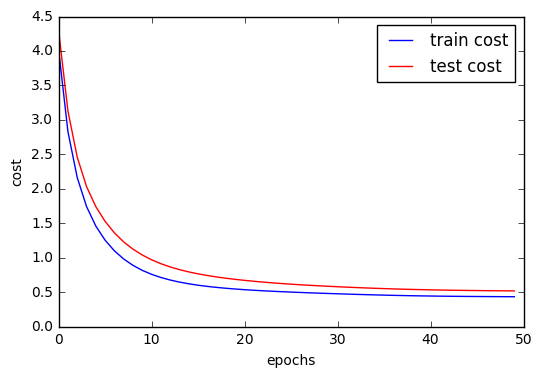

In [35]:
plt.plot(train_Data_cost, c='b', label='train cost')
plt.plot(test_Data_cost, c='r', label='test cost')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

## 学習精度のグラフ

エポックごとに学習精度が向上していく様子をプロットする。

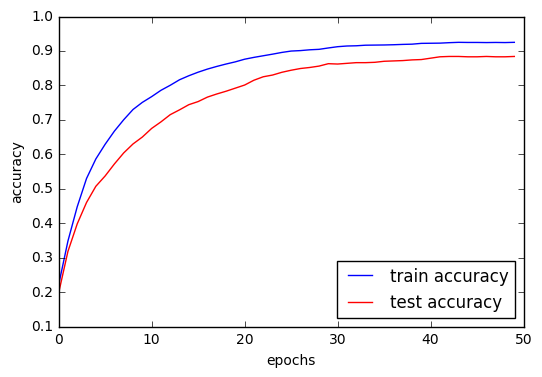

In [36]:
plt.plot(train_Data_acc, c='b', label='train accuracy')
plt.plot(test_Data_acc, c='r', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()

### 実際に予測してみる

学習後のパラメータを使って、訓練データとテストデータの精度を確認してみましょう。

In [37]:
hidden = np.dot(X_train, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_train, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

training accuracy: 0.93


In [38]:
hidden = np.dot(X_test, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_test, axis=1)
print ('test accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

test accuracy: 0.88


## L2正則化の重みの分布

入力層から隠れ層にかけての重みの値の分布をヒストグラムを使って確認してみます。

In [39]:
L2 = W1.reshape(78400, )

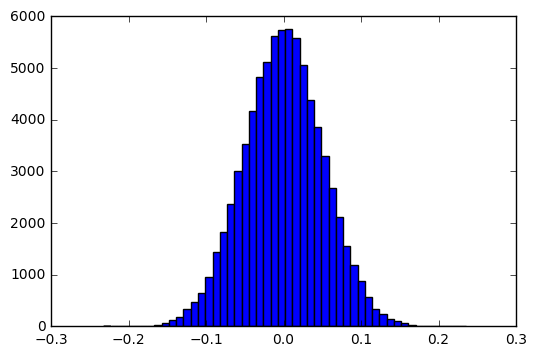

In [40]:
plt.hist(L2, bins=50)
plt.show()

０を中心に重みの値がバランスよく広がっていることがわかります。ネットワーク全体で入力データの特徴を拾っていることがわかります。

## L1正則化

オーバーフィッティング対策のもう１つの手法であるL1正則化を行なってみましょう。L2正則化と同様に、パラメータ更新関数 update_parameters を書き換えます。

**【課題２】** update_parameters_reg1()を実装してください。

**Note:**
$$w=w-\alpha\lambda sign(w) - \alpha\frac{\partial{C}}{\partial{w}}$$
$$b=b-\alpha\frac{\partial{C}}{\partial{b}}$$

In [50]:
#Coursedele-02 Step3 QuestionNumber2 862c70efa7d546a0d64dc986eff2b31a
def update_parameters_reg1(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate, reg):
    ###############START CODE HERE###############
    W1 = W1 - learning_rate * reg * np.sign(W1) - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1
    W2 = W2 - learning_rate * reg * np.sign(W2) - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    ################END CODE HERE################
    return W1, b1, W2, b2

**ファイルを保存後** 、次のセルを実行（Shift+Enter）で採点を行います。

In [51]:
%%bash
./validation_client.py dele-02 3 2 Step3_01.ipynb api.internal.zero2one.jp

Congraturation!
We give you 10 points out of 10 points.



update_parameters_reg1()の実装がおわったら、nn_model()のコードを流用してニューラルネットワークのモデルを構築します。

nn_model_reg1()を実装します。

ここでは、下記の通りパラメータ更新の関数 update_parameters() を update_parameters_reg1()に書き換えました。

下のセルをそのまま実行してください。

In [52]:
# ニューラルネットワークのモデルを構築
def nn_model_reg1(X, y, X_test,y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, reg, print_cost=False):

    # コスト/精度を記録するための配列
    train_Data_cost = []
    train_Data_acc = []
    test_Data_cost = []
    test_Data_acc = []
    
    #エポックのカウントとパラメータを初期化
    count = 0    
    W1,b1,W2,b2 = initialize_parameters(input_size, hidden_size, output_size)
     
    #エポック
    for i in range(epochs):
        #ミニバッチ
        for i in range(0, sample_size, batch_size):
         
            #ミニバッチ処理
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
        
            #フォワードプロパゲーション
            layer1_z, layer1_a, layer2_z, layer2_a = forward_propagation(X_batch, W1,b1,W2, b2)
            
            #バックプロパゲーション
            delta_W2, delta_b2, delta_W1, delta_b1 = backward_propagation(X_batch, y_batch, W2, layer1_z, layer1_a, layer2_z, layer2_a, batch_size)
            
            #パラメータの更新
            W1, b1, W2, b2 = update_parameters_reg1(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate, reg)

        
        #訓練データのエポックごとのコスト値
        train_output = forward_propagation(X, W1,b1,W2, b2)
        train_cost = compute_cost(y, train_output[3], sample_size)
        train_Data_cost.append(train_cost)
        
        #訓練データのエポックごとの精度
        train_acc = accuracy(y, train_output[3])
        train_Data_acc.append(train_acc)
        
        #テストデータのエポックごとのコスト値
        test_output = forward_propagation(X_test, W1,b1,W2, b2)
        test_cost = compute_cost(y_test, test_output[3], y_test.shape[0])
        test_Data_cost.append(test_cost)
        
        #テストデータのエポックごとの精度
        test_acc = accuracy(y_test, test_output[3])
        test_Data_acc.append(test_acc)

        #エポック数をカウント
        count += 1
        print('epochs：{0:.0f}'.format(int(count)), 'train cost：{0:.2f}'.format(train_cost),'train acc：{0:.2f}%'.format(train_acc*100))
    
    print("Finish Leaning!!")
    
    return train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2

nn_model_reg1()に各引数を与え、学習を実行します。ここでは以下のとおりパラメータの設定をおこなってください。

- input_size = 784
- hidden_size = 100
- output_size = 10
- epochs = 10
- sample_size = 55000
- batch_size = 100
- learning_rate = 0.1
- reg = 0.005

In [53]:
input_size = 784
hidden_size = 100
output_size = 10
epochs = 50
sample_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1
reg = 0.005 #正則化パラメータ

以下のセルを実行するとモデルの学習がはじまります。

In [54]:
train_Data_cost, train_Data_acc, test_Data_cost, test_Data_acc, W1, b1, W2, b2 = \
nn_model_reg1(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size, epochs, sample_size, batch_size, learning_rate, reg, print_cost=True)

epochs：1 train cost：4.58 train acc：22.37%
epochs：2 train cost：3.33 train acc：33.27%
epochs：3 train cost：2.61 train acc：42.23%
epochs：4 train cost：2.14 train acc：49.20%
epochs：5 train cost：1.82 train acc：54.63%
epochs：6 train cost：1.58 train acc：59.43%
epochs：7 train cost：1.41 train acc：62.73%
epochs：8 train cost：1.27 train acc：65.10%
epochs：9 train cost：1.16 train acc：67.60%
epochs：10 train cost：1.07 train acc：69.73%
epochs：11 train cost：0.99 train acc：71.70%
epochs：12 train cost：0.93 train acc：72.87%
epochs：13 train cost：0.88 train acc：74.33%
epochs：14 train cost：0.83 train acc：75.40%
epochs：15 train cost：0.79 train acc：76.60%
epochs：16 train cost：0.75 train acc：77.37%
epochs：17 train cost：0.72 train acc：78.27%
epochs：18 train cost：0.69 train acc：78.73%
epochs：19 train cost：0.67 train acc：79.33%
epochs：20 train cost：0.65 train acc：80.00%
epochs：21 train cost：0.63 train acc：80.23%
epochs：22 train cost：0.61 train acc：80.93%
epochs：23 train cost：0.59 train acc：81.33%
epochs：24 train cost

## コスト減少のグラフ

コスト関数が最適化されてコストが減少していく様子をプロットします。

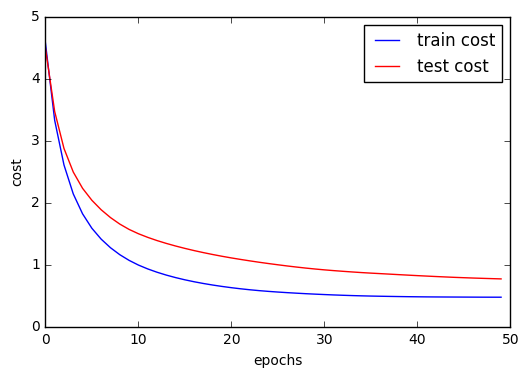

In [55]:
plt.plot(train_Data_cost, c='b', label='train cost')
plt.plot(test_Data_cost, c='r', label='test cost')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

## 学習精度のグラフ

エポックごとに学習精度が向上していく様子をプロットする。

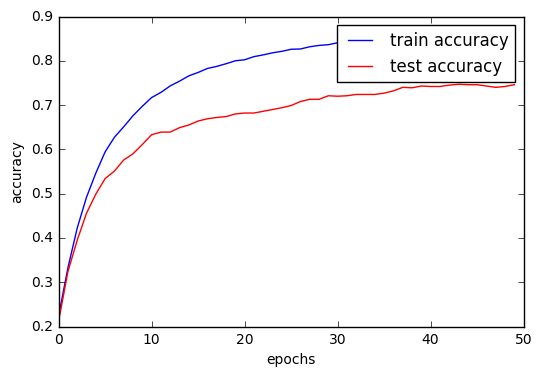

In [56]:
plt.plot(train_Data_acc, c='b', label='train accuracy')
plt.plot(test_Data_acc, c='r', label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### 実際に予測してみる

学習後のパラメータを使って、訓練データとテストデータの精度を確認してみましょう。

In [57]:
hidden = np.dot(X_train, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_train, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

training accuracy: 0.86


In [58]:
hidden = np.dot(X_test, W1) + b1
act1 = sigmoid(hidden)
output = np.dot(act1, W2) + b2
act2 = softmax(output)
predicted_class = np.argmax(act2, axis=1)
predicted_class_y_train = np.argmax(y_test, axis=1)
print ('test accuracy: %.2f' % (np.mean(predicted_class == predicted_class_y_train)))

test accuracy: 0.75


## L1正則化の重みの分布

入力層から隠れ層にかけての重みの値の分布をみてみます。

In [59]:
L1 = W1.reshape(78400, )

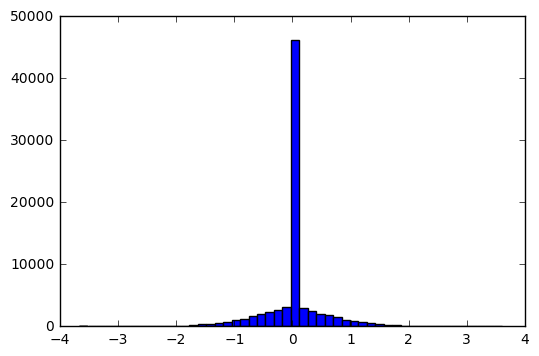

In [60]:
plt.hist(L1, bins=50)
plt.show()

L1正則化を行うと、正則化の制約条件よりスパース性が高くなります。疎な解を得やすくなります。

本演習例では多くのパラメータがゼロになっています。このようにほとんどゼロであるというデータの性質をスパース性といいます。

スパースだと何が良いのでしょうか？

- スパースなデータは、ほとんどの要素がゼロのため、「どこに何の数字がある」という情報だけ記録しておけば、大幅に使用メモリ削減になる。
- ゼロのところは計算する必要がないため、大幅な高速化に貢献する。
- どこに何があるという情報は、訓練データの構造を理解するのにも有用である。

以上のような性質があります。

# 早期終了

本演習の前半では過学習対策として、正則化を実装してきました。ニューラルネットワークはよく過学習を起こします。

そこでテストデータ（検証データ）の評価が良いときに学習を止めてしまうことで、過学習を起こす前のよくフィットしたパラメータを獲得する、もしくは無駄な学習コストを抑えることもできる早期終了の実装を行います。

大抵、テストデータ（検証データ）に対する評価が複数回悪化した場合に学習を止めます。

なぜならディープラーニングでは学習が停滞してしまう、あるいは悪化後に、能力がよくなることも考えられるからです。

１回だけで学習を止めてしまうのはもったいないかもしれませんが、ここでは実験データを用いてテストデータのコストが悪化したケースを想定し、早期終了を実装します。

以下のコードをそのまま実行してください。エポック（epochs）の回数が３０回、訓練データ（train_cost）とテストデータ（test_cost）のコストのデータをロードします。

In [61]:
import numpy as np
import matplotlib.pyplot as plt
epochs = np.loadtxt('./dataset/epochs.csv')
train_cost = np.loadtxt('./dataset/train_cost.csv')
test_cost = np.loadtxt('./dataset/test_cost.csv')

下のセルを実行して、読み込んだデータを可視化します。

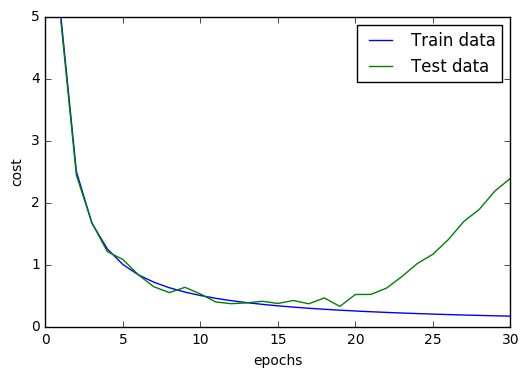

In [62]:
plt.plot(epochs, train_cost, label="Train data")
plt.plot(epochs, test_cost, label="Test data")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

１５エポックくらいまではコストがいい感じに下がっていますが、１５エポックを境に突如テストデータのコストが上昇してしまい、過学習を起こしてしまったモデルのケースです。早期終了の方法はさまざまな方法が考えられますが、ここでは極端な例として訓練集合とテスト集合に関してのコストの値の差の絶対値が１を超えたしまったときプログラムを終了するといったケースを考えて実装します。

**【課題３】** early_stopping()を実装してください。

In [72]:
#Coursedele-02 Step3 QuestionNumber3 7947f78be397ca30adb98d8b32decb88
def early_stopping(train_cost, test_cost, print_cost = False):
    count = 0
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    for z1, z2 in zip(train_cost, test_cost):
        if np.absolute(z1 - z2) >= 1:
            if print_cost == True:
                print("コストの絶対値の差が１を超えたため学習を終了" )
            break
        else:
            if print_cost == True:
                print("エポック：{}".format(count), "コストの絶対値の差：", np.absolute(z1 - z2) )
            count +=1
            continue
    ################END CODE HERE################
    return np.absolute(z1 - z2)

**ファイルを保存後** 、次のセルを実行（Shift+Enter）で採点を行います。

In [75]:
%%bash
./validation_client.py dele-02 3 3 Step3_01.ipynb api.internal.zero2one.jp

Congraturation!
We give you 10 points out of 10 points.



In [74]:
early_stopping(train_cost, test_cost, print_cost = True)

エポック：0 コストの絶対値の差： 0.07557297998892754
エポック：1 コストの絶対値の差： 0.059052772349942106
エポック：2 コストの絶対値の差： 0.008292537767421448
エポック：3 コストの絶対値の差： 0.04289820991249638
エポック：4 コストの絶対値の差： 0.08142967765997478
エポック：5 コストの絶対値の差： 0.0007062033307673188
エポック：6 コストの絶対値の差： 0.07369294374439406
エポック：7 コストの絶対値の差： 0.07799222405111728
エポック：8 コストの絶対値の差： 0.0764486590728386
エポック：9 コストの絶対値の差： 0.025283739805557315
エポック：10 コストの絶対値の差： 0.059288829690399336
エポック：11 コストの絶対値の差： 0.04886582436591047
エポック：12 コストの絶対値の差： 0.0032255384669148124
エポック：13 コストの絶対値の差： 0.04989584143632725
エポック：14 コストの絶対値の差： 0.038048566319644206
エポック：15 コストの絶対値の差： 0.10673643312071224
エポック：16 コストの絶対値の差： 0.07234899564544617
エポック：17 コストの絶対値の差： 0.18309563344527535
エポック：18 コストの絶対値の差： 0.060934903387208805
エポック：19 コストの絶対値の差： 0.2663376657374398
エポック：20 コストの絶対値の差： 0.2796652336380832
エポック：21 コストの絶対値の差： 0.39051299701322095
エポック：22 コストの絶対値の差： 0.5876431244363143
エポック：23 コストの絶対値の差： 0.807933484010961
エポック：24 コストの絶対値の差： 0.965362428240907
コストの絶対値の差が１を超えたため学習を終了


1.2100915536012253